# Sheet 2

In [79]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import detrend
import scipy.io
import math 
# Import data
data = scipy.io.loadmat("ex2file1.mat")

In [13]:
print(data.keys())

array({'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue Nov  5 11:10:09 2019', '__version__': '1.0', '__globals__': [], 'DLPFC1': array([[ 2.2855  ],
       [ 0.85457 ],
       [-0.26151 ],
       [-1.1941  ],
       [-1.279   ],
       [-1.3238  ],
       [-0.58961 ],
       [-1.1633  ],
       [-1.5361  ],
       [-1.6843  ],
       [-1.0633  ],
       [-0.21123 ],
       [ 0.29068 ],
       [ 1.1061  ],
       [ 0.96371 ],
       [-0.55804 ],
       [-1.2362  ],
       [-1.6596  ],
       [-2.5186  ],
       [-2.7868  ],
       [-2.6213  ],
       [-3.6002  ],
       [-4.0044  ],
       [-4.5279  ],
       [-3.7252  ],
       [-3.5887  ],
       [-2.9848  ],
       [-0.49111 ],
       [ 0.67079 ],
       [-0.058772],
       [ 0.43937 ],
       [ 1.3549  ],
       [-0.58531 ],
       [-0.6419  ],
       [ 0.1304  ],
       [ 0.2799  ],
       [-0.80414 ],
       [-0.98203 ],
       [-0.99122 ],
       [-0.76987 ],
       [-0.67481 ],
       [ 0.13987 ],
       

## Task 1. Univariate AR models

### 1.
**Write down the formula for an AR(4) model and explain how it can be rewritten as a VAR(1) model. Using this, how would you determine an estimate for the parameters $\{a_i\}_{0:4}$? Write down as a formula and compute numerically.**

In [41]:
dlpfc1 = data['DLPFC1']
dlpfc1 = dlpfc1.flatten()

An $AR(4)$ model is of the form
$$x_t = a_0 + \sum_{i = 1}^{4} a_{i} x_{t-i} + \epsilon_t, \quad \epsilon_t \sim W(0,\sigma^2)$$
for $t = 1,...,T$. $x_t$ is stationary, and $W(0,1)$ denotes a white noise distribution with mean $0$ and variance $\sigma^2$.

The time series can writen as the following VAR(1) process.
$$y_t = a + A y_{t-1} + \epsilon_t'$$
Where  $y_t = (x_t, x_{t-1}, x_{t-2}, x_{t-3})^T$, $a = (a_0,0,0,0)^T$, $A = \begin{pmatrix} a_1 & a_2 & a_3 & a_4 \\ 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0\\ 0 & 0 & 1 & 0\end{pmatrix}$, $\epsilon_t' = (\epsilon_t, 0,0,0)^T$ 

That the two models are equivalent means that the results we show for one of them can be used for the other. We now that the MLE estimates $\hat{a}$ of $\{a_i\}_{0:4}$ for the AR(4) model (and therefore also the VAR(1) model) are given by:
$$\hat{a} = (X_p^TX_p)^{-1}X^T_p x_T$$
Where $X_p$ is the design matrix of dimension $(T-4)$ x $5$ where the first column is ones, the second column $x_4, ..., X_T$, the third $x_3,...,x_{T-1}$ and so on. $x_T$ is the vector of observations, where we discard the first four observations (as we do not have enough preceding observations). 

We calculate the estimates

In [44]:
Xp = np.column_stack([
    np.ones((len(dlpfc1)-4)),  
    dlpfc1[3:-1],
    dlpfc1[2:-2],
    dlpfc1[1:-3],
    dlpfc1[0:-4]
])

a_hat = np.linalg.inv(Xp.T @ Xp) @ (Xp.T @ dlpfc1[4:])
print(np.round(a_hat, 3))

[ 0.003  1.249 -0.483  0.243 -0.17 ]


### 2.
**Compute the log-likelihood of an AR(4) model. Please write the derivation down explicitly.**

Assuming normality of the residuals the log likelihood of the model is
$$\mathcal{l}(\theta) = \sum_{i=1}^T - \frac{1}{2}\log (2\pi\sigma^2)  - \frac{1}{2}\frac{(x_t - \mu_t)^2}{\sigma^2}$$
Where $\mu_t = \sum_{i = 1}^{4} a_{i} x_{t-i}$. 
In order to compute the log likelihood, we will need estimates of $\mu_t$ and an estimate of $\sigma^2$. We can obtain estimates of $\mu_t$ by using our estimates $a_1, a_2, a_3, a_4$. We do this below

In [76]:
hat_mu_t = [a_hat[0] + np.sum(np.flip(a_hat[1:5]) * dlpfc1[t:(t + 4)]) for t in range(len(dlpfc1)-4)]

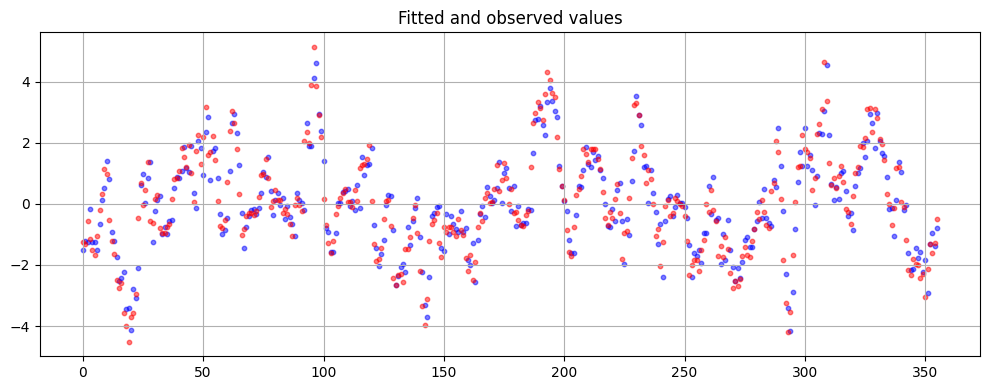

In [98]:
plt.figure(figsize=(10, 4))
plt.scatter(range(0, len(hat_mu_t)), hat_mu_t, color = "blue", s = 10, alpha = 0.5)
plt.scatter(range(0, len(hat_mu_t)), dlpfc1[4:], color = "red", s = 10, alpha=0.5)
plt.title('Fitted and observed values')
plt.grid(True)
plt.tight_layout()
plt.show()

We use the following estimate of $\sigma^2$
$$\hat{\sigma}^2=\frac{1}{T-p} (x_T - \hat{\mu}_t)^T(x_T - \hat{\mu}_t)$$

In [77]:
hat_sigma2 = 1/(len(dlpfc1) - 4) * (dlpfc1[4:] - hat_mu_t) @ (dlpfc1[4:] - hat_mu_t)

Now we can compute the log likelihood estimate

In [82]:
sum(-0.5 * math.log(2 * math.pi * hat_sigma2) - 0.5 * (dlpfc1[4:] - hat_mu_t)*(dlpfc1[4:] - hat_mu_t)/hat_sigma2)

-365.77319316608987

### 3. 
**Plot the residuals of the model in a histogram. What do they look like? What do you expect?**

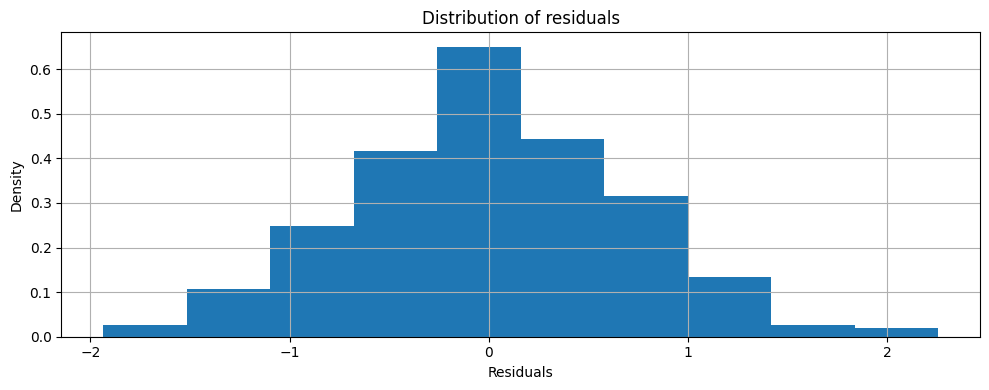

In [88]:
ress = dlpfc1[4:] - hat_mu_t
index = range(len(dlpfc1)-4)

plt.figure(figsize=(10, 4))
plt.hist(ress, density = True)
plt.title('Distribution of residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()
plt.show()

They look fairly normally distributed, with mean $0$. The mean $0$ is achieved by construction of the model, while the normality assumption is not. It is useful to observe that the residuals indeed satisfy the normality assumption, as this can be used for inference. 

### 4. 
**Compute the log-likelihood of an AR(n) model, with n ranging from 1...5. How does the likelihood change when you increase the order of the model?**

In [ ]:
Xp_1 = np.column_stack([
    np.ones((len(dlpfc1)-1)),  
    dlpfc1[0:-1]])
Xp_2 = np.column_stack([
    np.ones((len(dlpfc1)-2)),  
    dlpfc1[1:-1],
    dlpfc1[0:-2]])
Xp_3 = np.column_stack([
    np.ones((len(dlpfc1)-3)),  
    dlpfc1[3:-1],
    dlpfc1[2:-2],
    dlpfc1[1:-3],
    dlpfc1[0:-4]])
Xp_5 = np.column_stack([
    np.ones((len(dlpfc1)-5)),  
    dlpfc1[4:-1],
    dlpfc1[3:-2],
    dlpfc1[2:-3],
    dlpfc1[1:-4],
    dlpfc1[0:-5]])

In [ ]:
def loglik(des_mat):


a_hat = np.linalg.inv(Xp.T @ Xp) @ (Xp.T @ dlpfc1[4:])
